In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '20'
import sys

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy as sp
#import colorcet as cc
import matplotlib.pyplot as plt
import libpysal as lps
import random
from matplotlib import rcParams
import seaborn as sns
import time
sc.set_figure_params(
    scanpy=True, dpi_save=600, vector_friendly=True, format="pdf",
    facecolor=(1.0, 1.0, 1.0, 0.0), transparent=False
)
rcParams["savefig.bbox"] = "tight"

/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


In [2]:
# cell cycle marker list from https://github.com/hbc/tinyatlas/blob/master/cell_cycle/Homo_sapiens.csv
## cc = pd.read_csv('data/cell_cycle_markers.txt')
## ccmap = pd.read_csv('data/cc_name_map.txt',sep='\t',header=None, index_col=0)
## cc['gene_name'] = ccmap.loc[cc['geneID'],1].tolist()
## cc.to_csv('data/cell_cycle_markers.txt',index=False)

### False and true examples of graph-based correlation

In [3]:
# Plot the original feature abundance
anndat_mod1 = ad.read_h5ad('../data/10XMultiome/PBMC_10X_GEX.h5ad')
anndat_mod2 = ad.read_h5ad('../data/10XMultiome/PBMC_10X_ATAC.peak.h5ad')

anndat_mod1.X = anndat_mod1.layers['counts'].copy()
rna_umap = pd.read_csv('../data/10XMultiome/PBMC.rna.umap.csv').to_numpy()
anndat_mod1.obsm['X_umap'] = rna_umap
anndat_mod2.obsm['X_umap'] = rna_umap

sc.pp.normalize_total(anndat_mod1)
sc.pp.normalize_total(anndat_mod2)
sc.pp.log1p(anndat_mod1)
sc.pp.log1p(anndat_mod2)

anndat_mod1 = anndat_mod1[anndat_mod1.obs['seurat_annotations'].isin(['CD4 Naive','CD4 TCM','CD4 TEM'])]
anndat_mod2 = anndat_mod2[anndat_mod2.obs['seurat_annotations'].isin(['CD4 Naive','CD4 TCM','CD4 TEM'])]


sc.pp.highly_variable_genes(anndat_mod1)
anndat_mod1.raw = anndat_mod1

anndat_mod1 = anndat_mod1[:, anndat_mod1.var.highly_variable]
sc.pp.scale(anndat_mod1, max_value=10)

sc.tl.pca(anndat_mod1, svd_solver='randomized', use_highly_variable=False)
sc.pp.neighbors(anndat_mod1, n_neighbors=20, n_pcs=30)
sc.tl.umap(anndat_mod1)

anndat_mod2.obsm['X_umap'] = anndat_mod1.obsm['X_umap']
anndat_mod2.obsm['X_pca'] = anndat_mod1.obsm['X_pca']

anndat_mod1 = ad.read_h5ad('../data/PBMC_10X_GEX.h5ad')
anndat_mod1.X = anndat_mod1.layers['counts'].copy()
sc.pp.normalize_total(anndat_mod1)
sc.pp.log1p(anndat_mod1)
anndat_mod1 = anndat_mod1[anndat_mod1.obs['seurat_annotations'].isin(['CD4 Naive','CD4 TCM','CD4 TEM'])]

anndat_mod1.obsm['X_umap'] = anndat_mod2.obsm['X_umap']
anndat_mod1.obsm['X_pca'] = anndat_mod2.obsm['X_pca']


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
cc = pd.read_csv('../data/cell_cycle_markers.txt')
s_genes = cc.loc[cc['phase']=='S','gene_name'].tolist()
g2m_genes = cc.loc[cc['phase']=='G2/M','gene_name'].tolist()

sc.tl.score_genes_cell_cycle(anndat_mod1, s_genes, g2m_genes)

/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


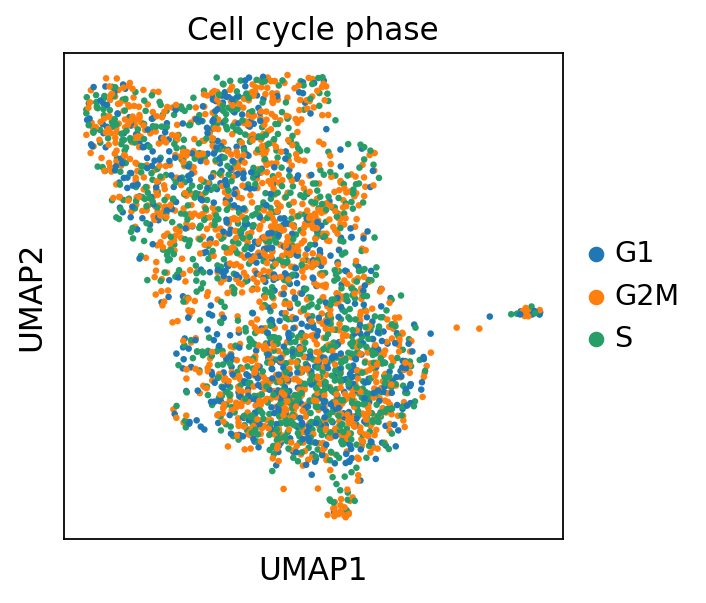

In [10]:
f = sc.pl.umap(anndat_mod1, color=['phase'], size=35, return_fig=True, title='Cell cycle phase')
f.savefig('plots/figure2C1.pdf',dpi=300)

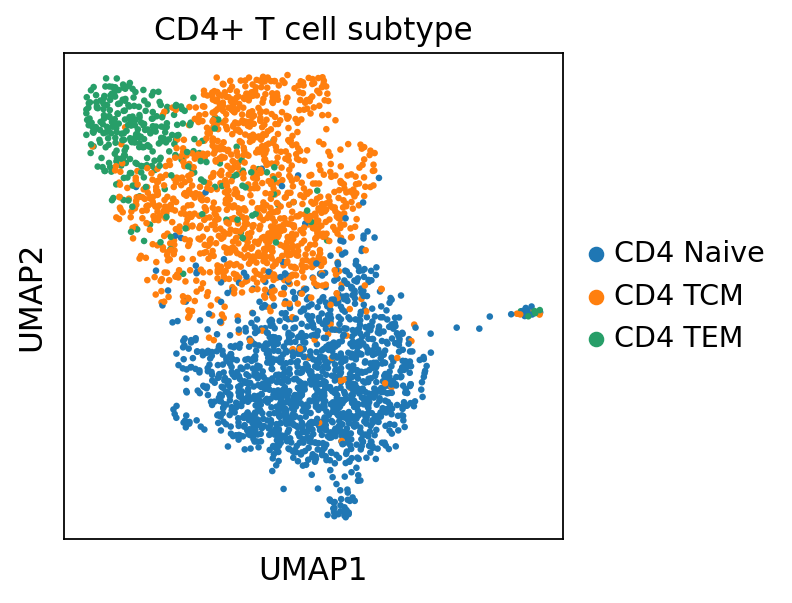

In [8]:
f = sc.pl.umap(anndat_mod1, color=['seurat_annotations'], size=35, return_fig=True, title='CD4+ T cell subtype')
f.savefig('plots/figure2C2.pdf',dpi=300)

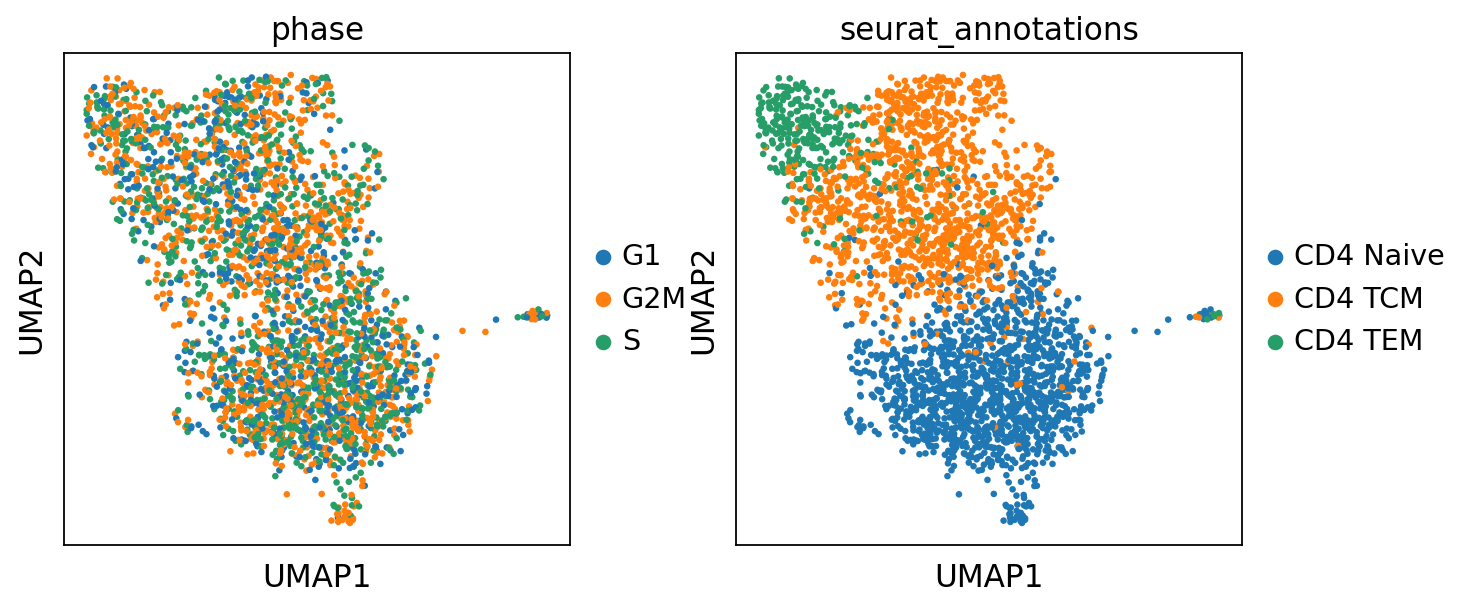

In [5]:
sc.pl.umap(anndat_mod1, color=['phase','seurat_annotations'], size=35)


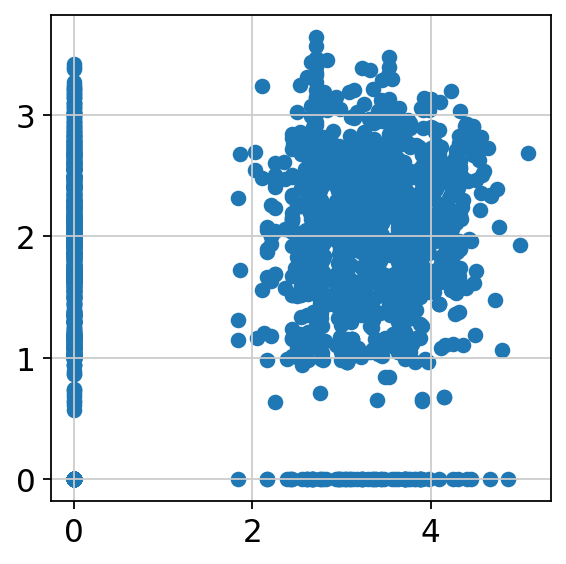

In [5]:
anndat_multiome = ad.read_h5ad('../data/10XMultiome/10XPBMC.CD4T.pseudo.h5ad')
plt.scatter(anndat_multiome[:,'CDC14B'].X.flatten(), anndat_multiome[:,'chr9-96618413-96620300'].X.flatten())

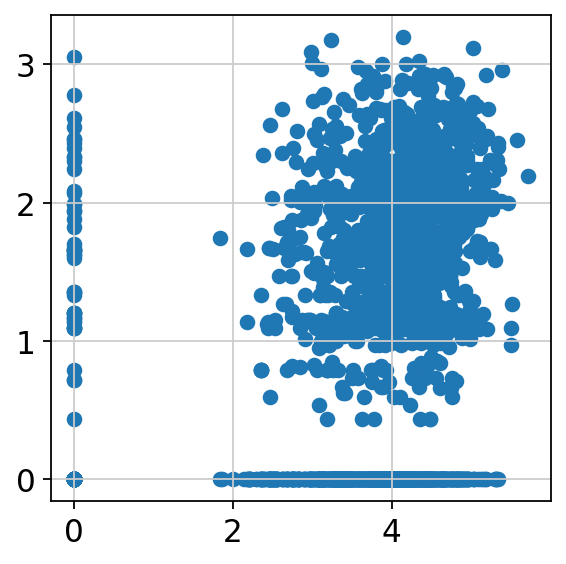

In [6]:
plt.scatter(anndat_multiome[:,'TARBP1'].X.flatten(), anndat_multiome[:,'chr1-234486742-234489041'].X.flatten())

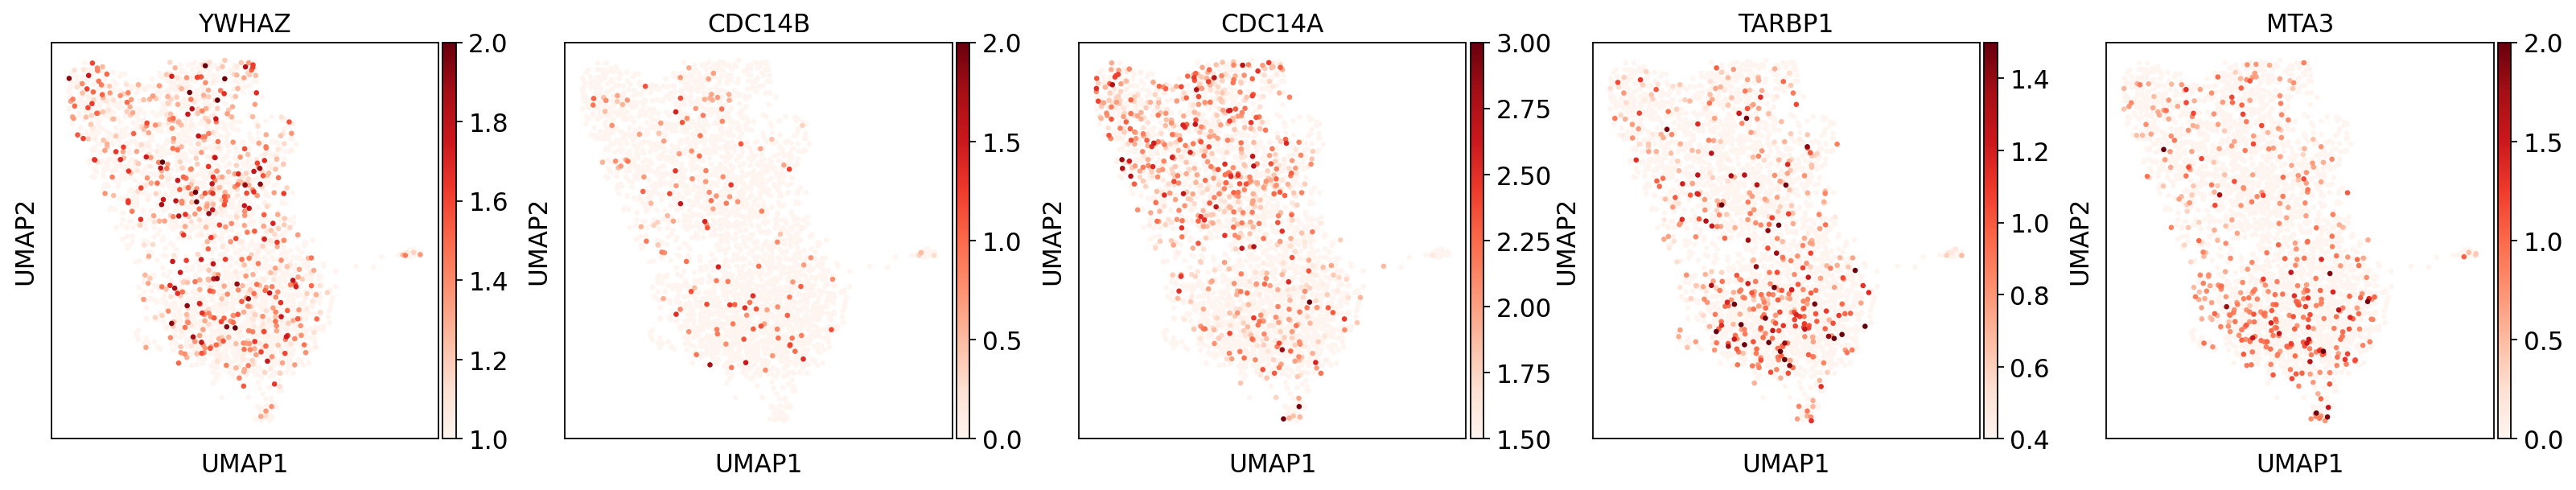

In [6]:
sc.pl.umap(anndat_mod1, color=['YWHAZ','CDC14B','CDC14A','TARBP1','MTA3'], cmap='Reds',
           vmin=[1.0,0.0,1.5,0.4,0.0], vmax=[2.0,2.0,3.0,1.5,2.0], size=35, ncols=5)


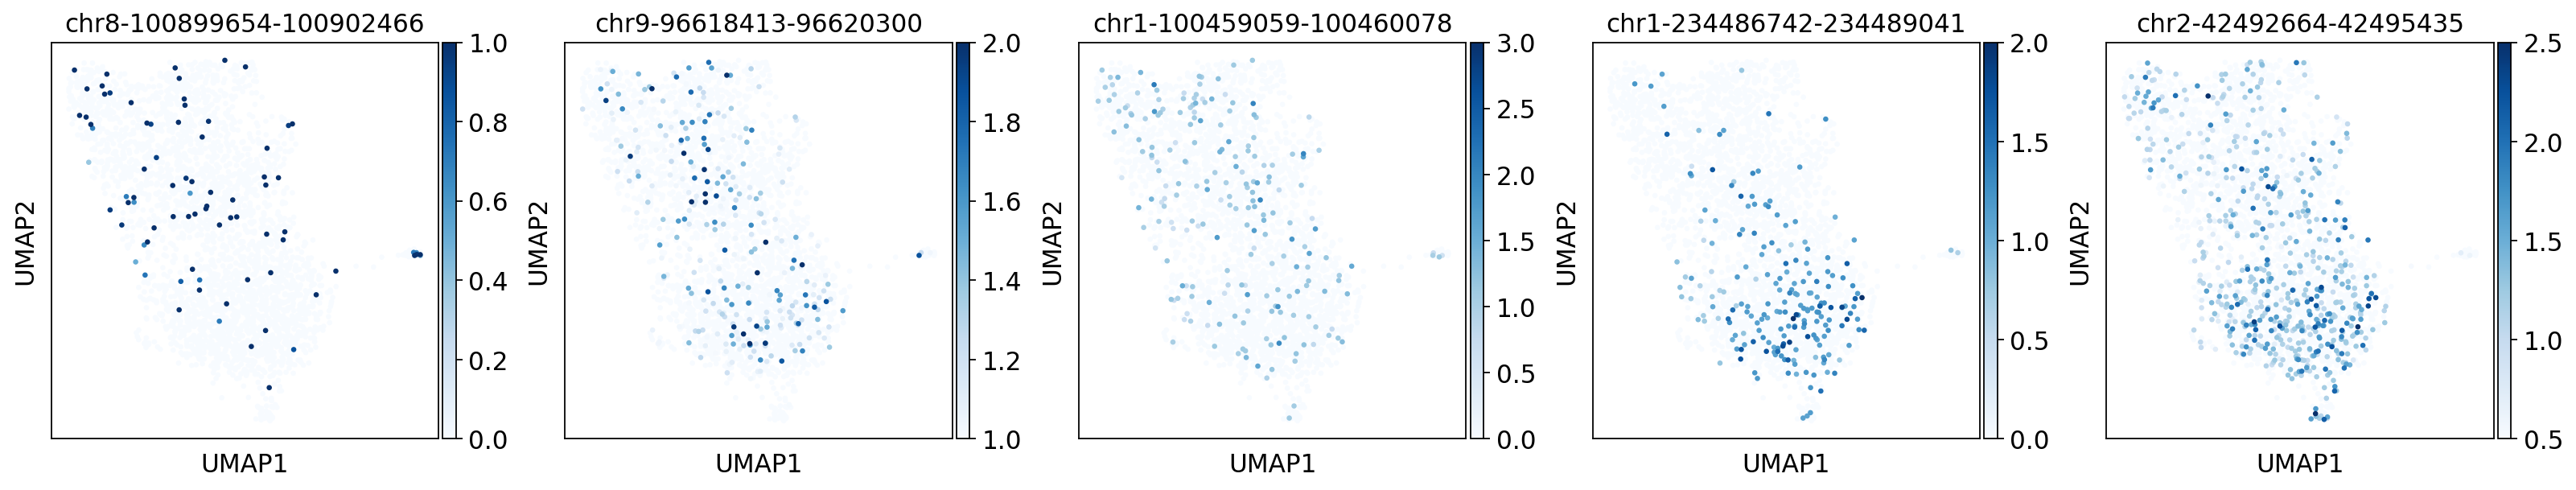

In [7]:
sc.pl.umap(anndat_mod2, color=['chr8-100899654-100902466','chr9-96618413-96620300',
                               'chr1-100459059-100460078','chr1-234486742-234489041',
                               'chr2-42492664-42495435'], cmap='Blues',
           vmin=[0,1,0,0,0.5], vmax=[1,2,3,2,2.5], size=35, ncols=5)

### Local L examples in CD4+ T cells

Load data

In [8]:
# Calculate Moran's I
import multiome.graph_measure as graph_measure
ad_pb_ct = ad.read_h5ad('../data/10XMultiome/10XPBMC.CD4T.pseudo.h5ad')
ad_pb_ct = graph_measure.Morans_I(ad_pb_ct)

Following changes made to the AnnData object:
	Moran's I value saved in var['Morans.I']
7.269s past


In [9]:
# Calculate local L
start = time.time()
#peaks_nearby = ad_pb_ct.uns['peaks_nearby'].copy()
ad_pb_ct = graph_measure.Global_L(ad_pb_ct, permutations=0)
#peaks_nearby[['L','L.p_value','L.FDR']] = global_L_df.to_numpy()
print('Finished in %.2fs.'%(time.time()-start))

start = time.time()
ad_pb_ct = graph_measure.Local_L(ad_pb_ct,
                                 I_cutoff=-1,
                                 pct_cutoff=0,
                                 dropout_rm=True,
                                 permutations=0)

print('Finished in %.2fs.'%(time.time()-start))


Calculating global graph-based correlation value...
Following changes made to the AnnData object:
	Global L results and QC metrics updated in uns['peaks_nearby'].
Finished in 11.24s.
Filtering features by Moran's I and feature sparsity in single-cell data...
Previously calculated Moran's I found.
Keep features with Moran's I > -1 and at least 0% expressed in single-cell data...
112924 pairs left for graph-based correlation L calculation.

Calculating local graph-based correlation value...
Set L to 0 for cells with no expression on either feature of a certain pair...
Following changes made to the AnnData object:
	Graph-based Pearson Correlation results saved in uns['Local_L']
	uns['peaks_nearby']['Local_L'] added indicates feature selected for local L calculation or not.
Finished in 23.76s.


In [10]:
peaks_nearby = ad_pb_ct.uns['peaks_nearby'].copy()
peaks_nearby['absL'] = np.abs(peaks_nearby['L'])

#### Visualization

In [11]:
import multiome.visualization as visualization
import multiome.data_preparation as data_preparation


RORA and chr15-60649315-60650653


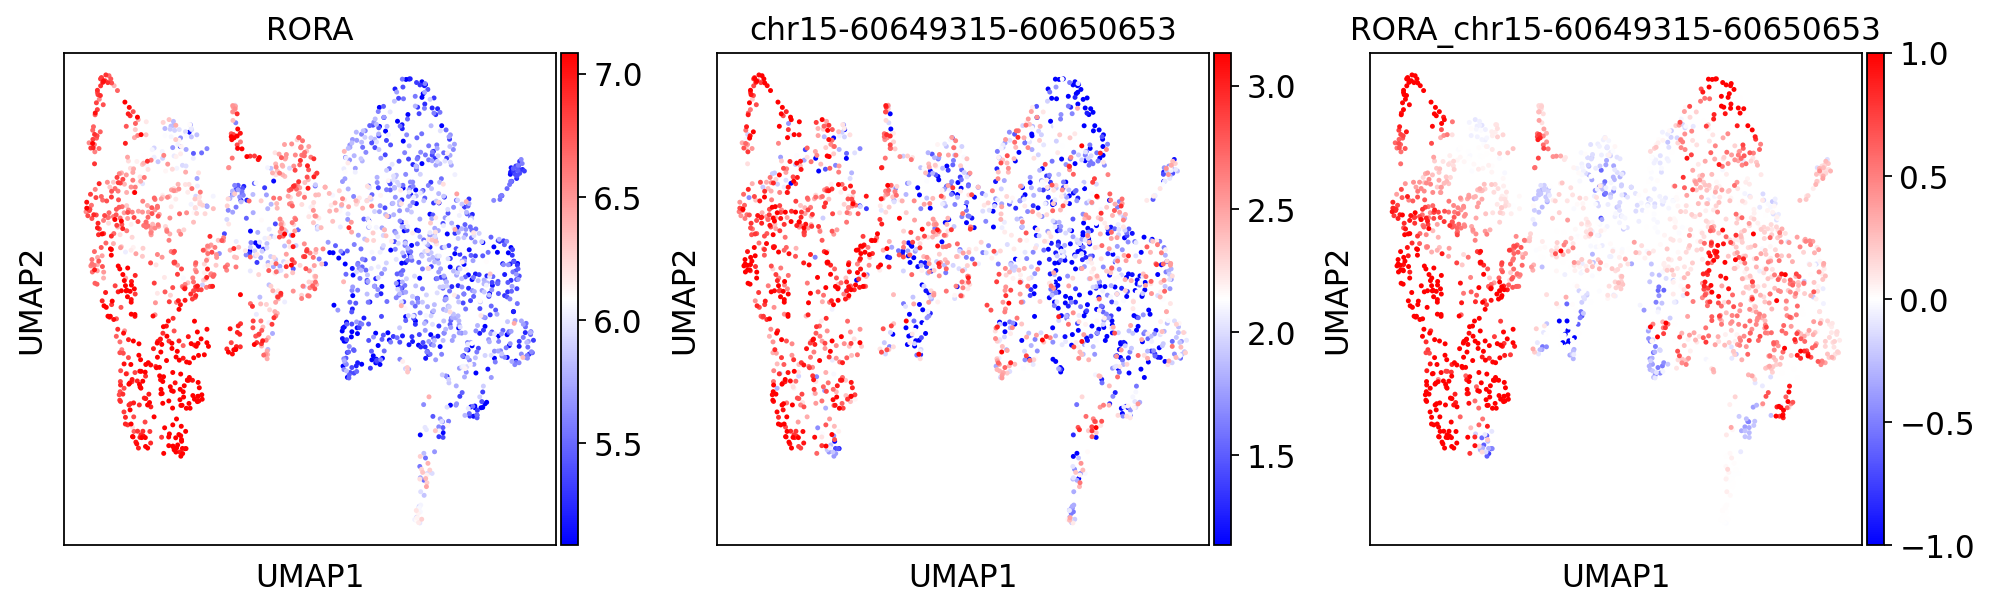

Mapping back from mini-bulk to single-cell data...

Compensating missing cells by its 5 neighbors in X_pca...

Following infos added to the AnnData:
	RORA_chr15-60649315-60650653 labels	obs['RORA_chr15-60649315-60650653']


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


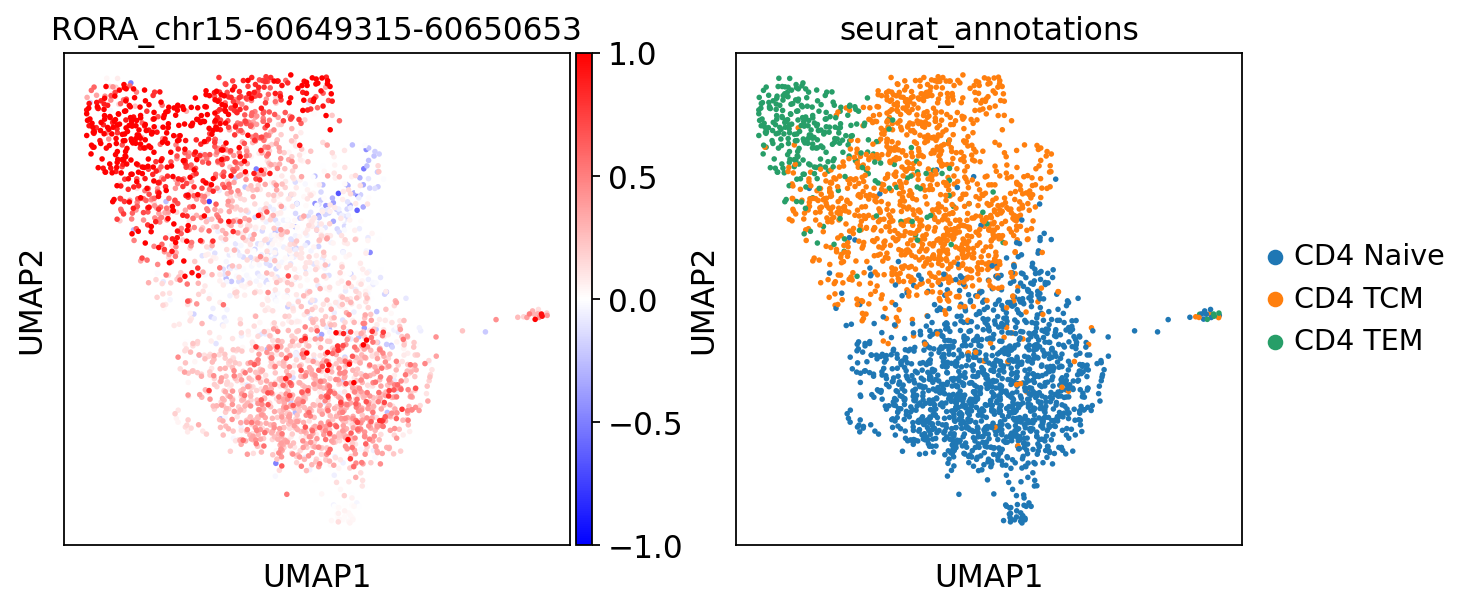

PSMA1 and chr11-14414675-14415776


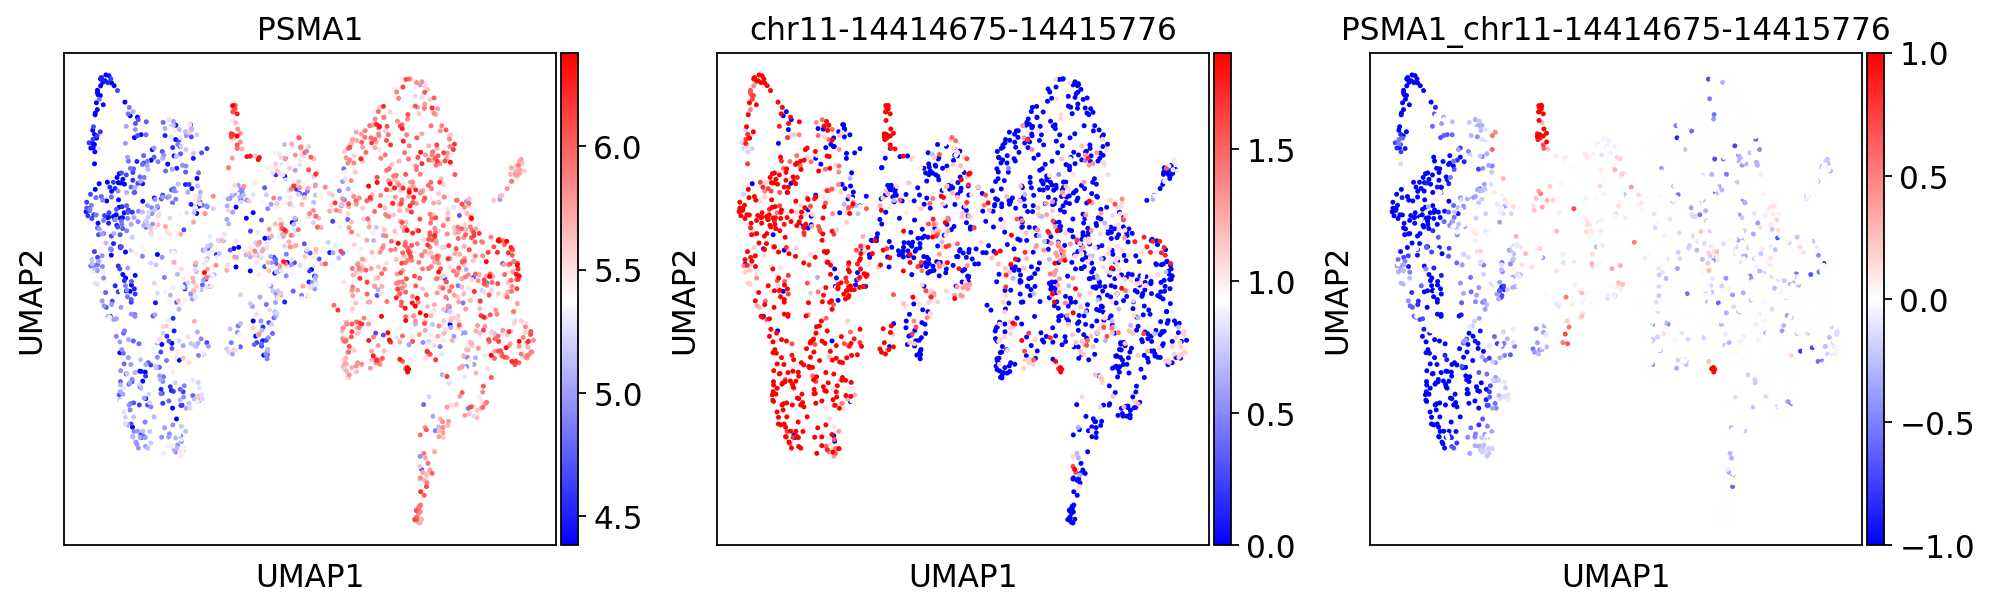

Mapping back from mini-bulk to single-cell data...

Compensating missing cells by its 5 neighbors in X_pca...

Following infos added to the AnnData:
	PSMA1_chr11-14414675-14415776 labels	obs['PSMA1_chr11-14414675-14415776']


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


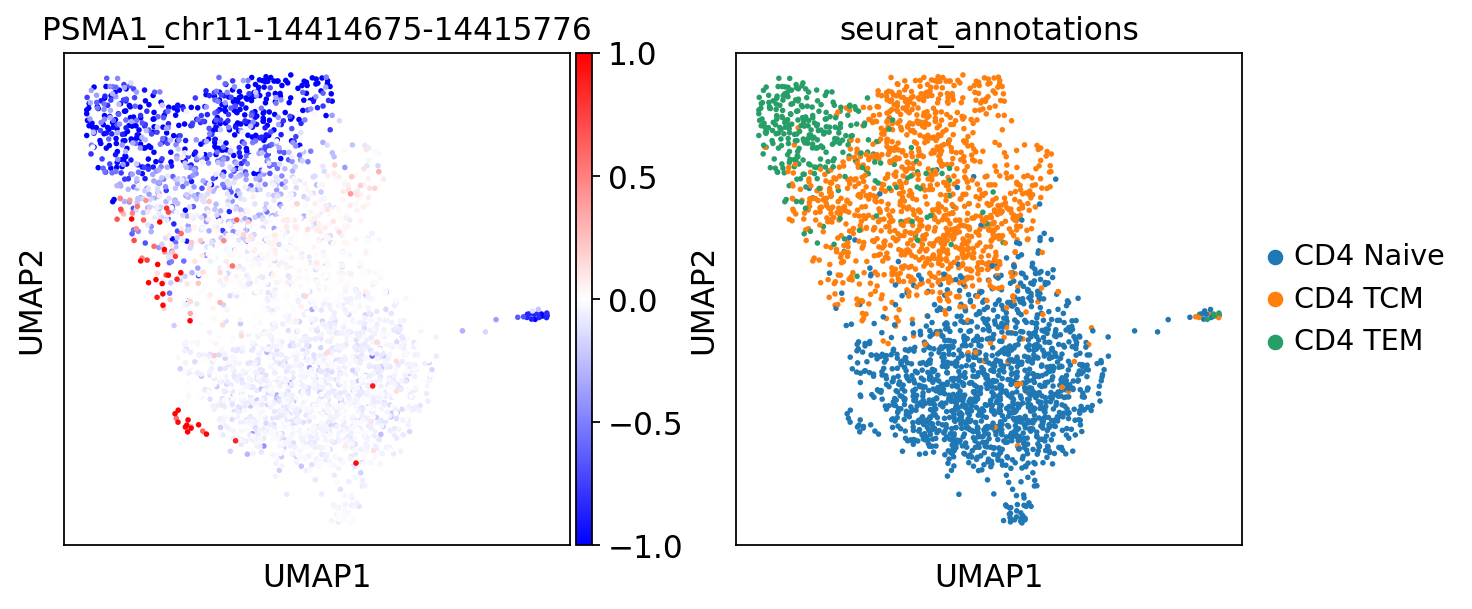

ETV6 and chr12-11980092-11982018


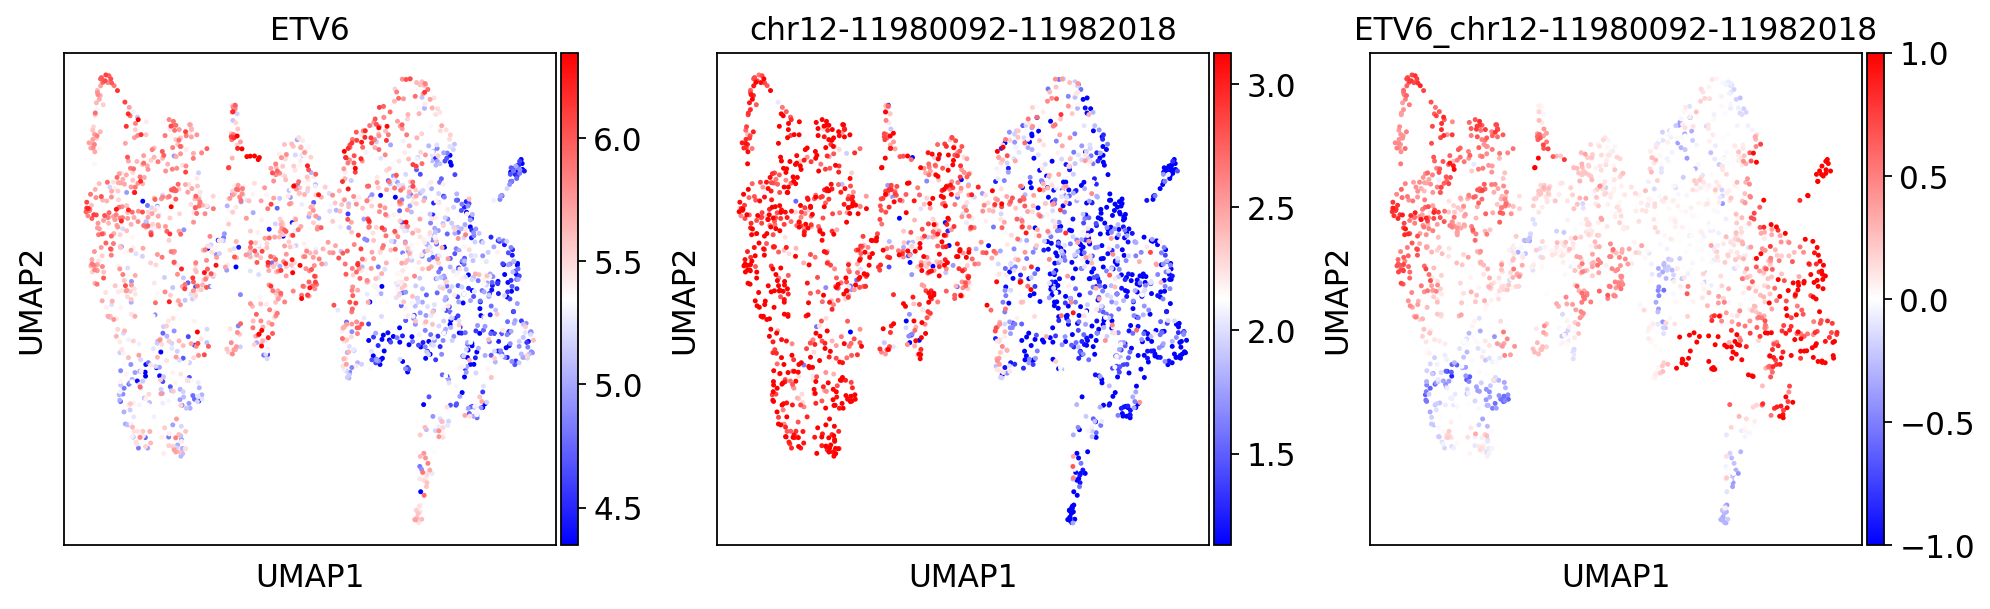

Mapping back from mini-bulk to single-cell data...

Compensating missing cells by its 5 neighbors in X_pca...

Following infos added to the AnnData:
	ETV6_chr12-11980092-11982018 labels	obs['ETV6_chr12-11980092-11982018']


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


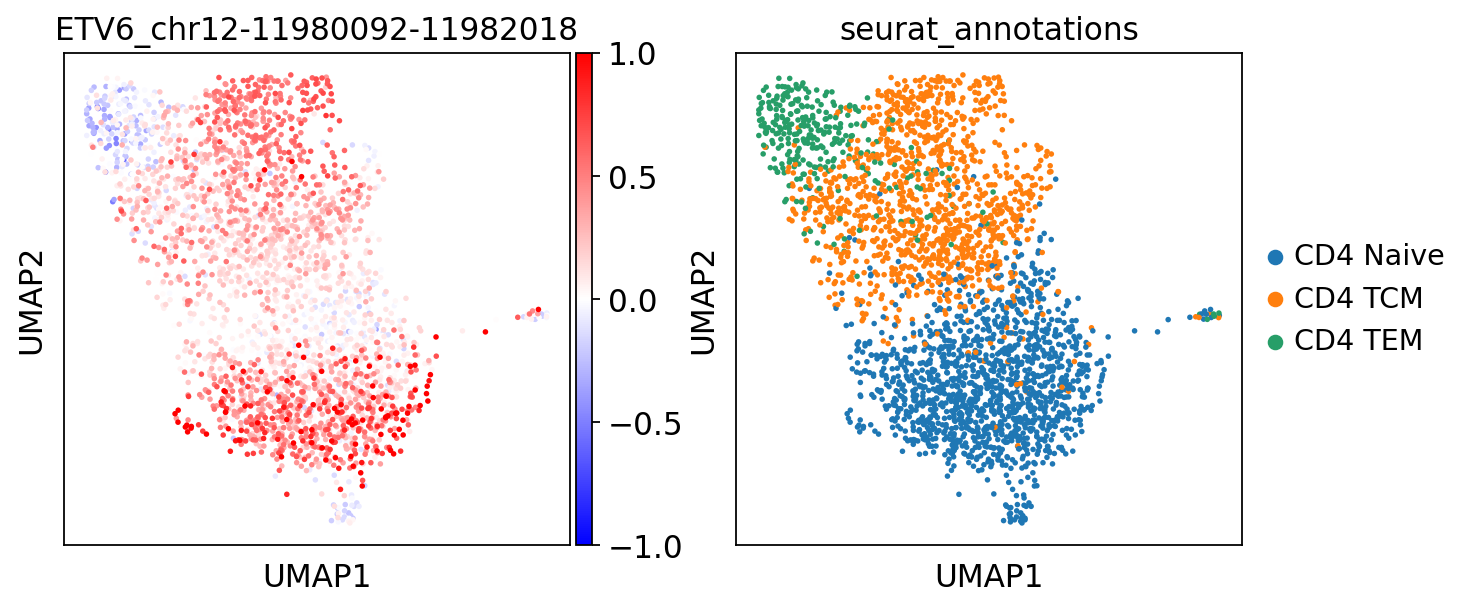

TIAM1 and chr21-31557431-31560364


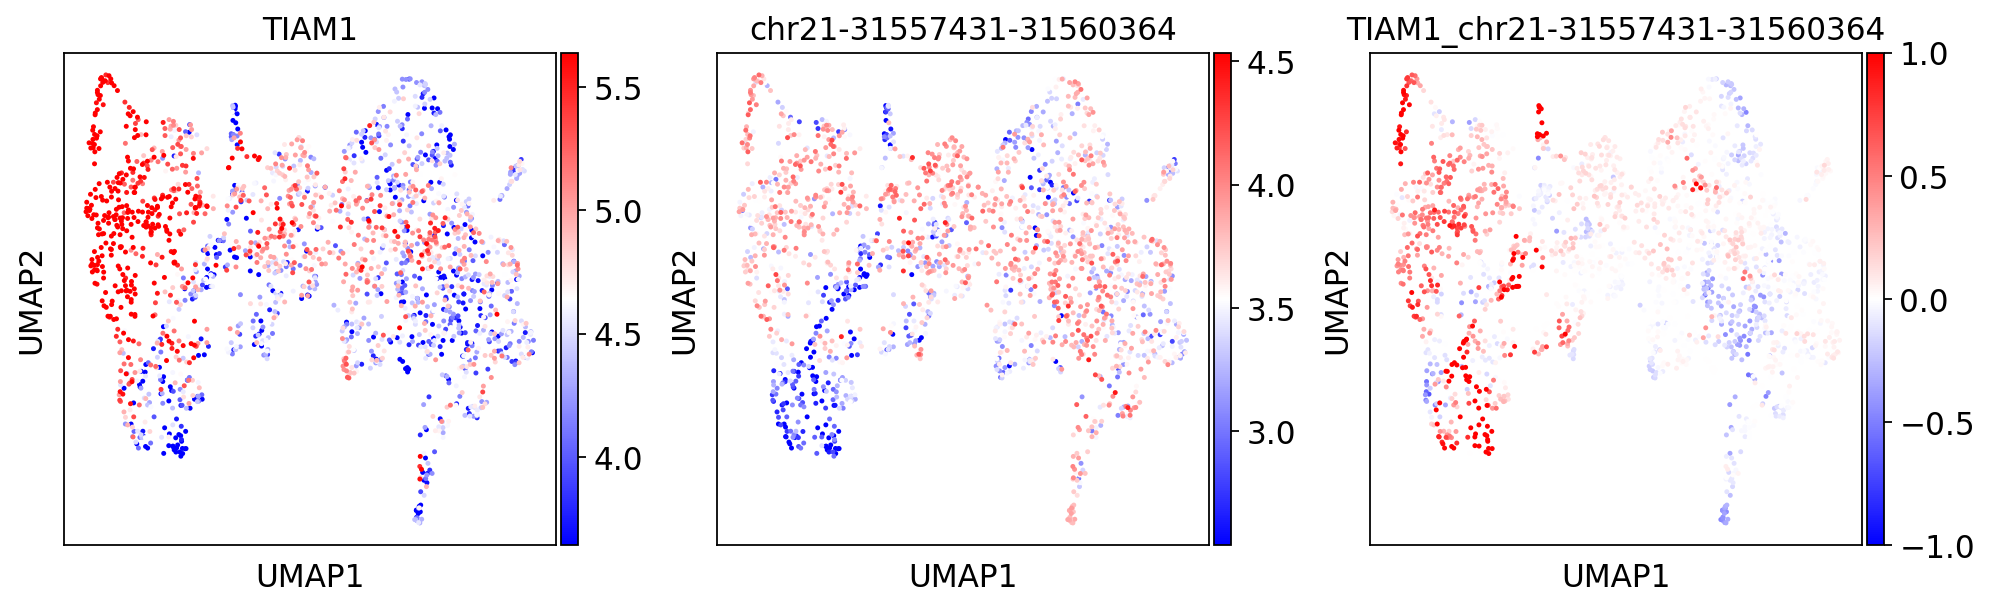

Mapping back from mini-bulk to single-cell data...

Compensating missing cells by its 5 neighbors in X_pca...

Following infos added to the AnnData:
	TIAM1_chr21-31557431-31560364 labels	obs['TIAM1_chr21-31557431-31560364']


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


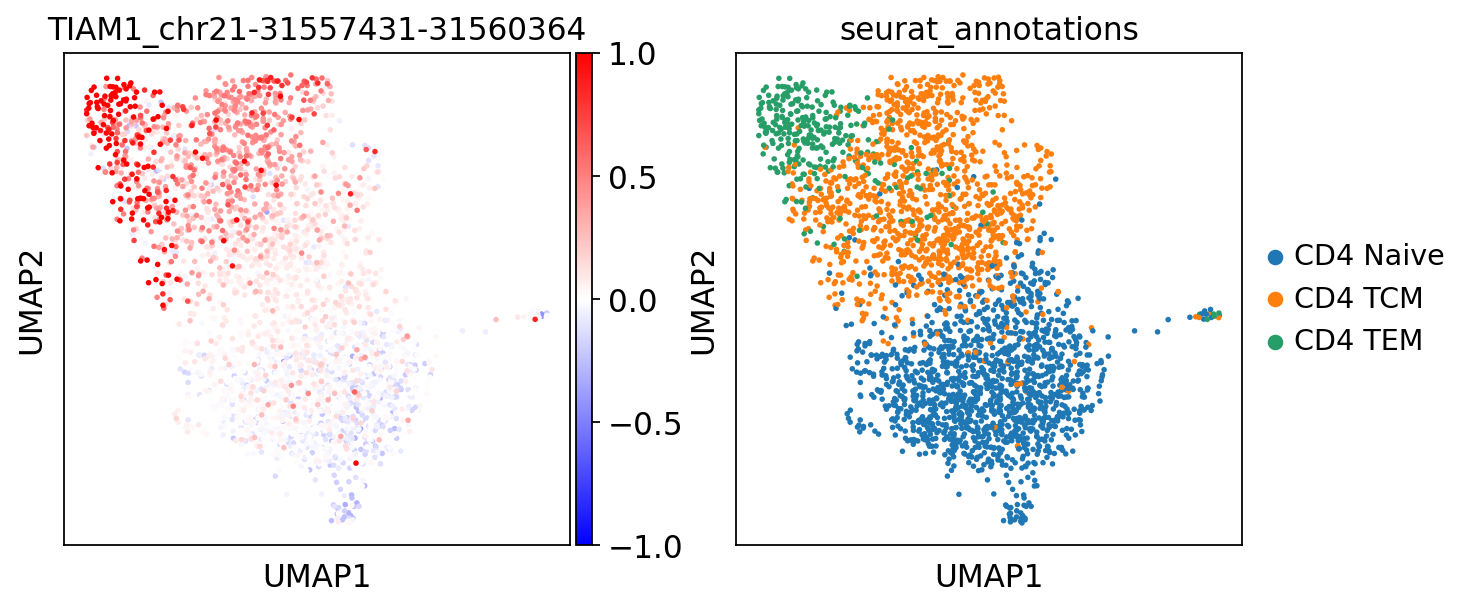

In [12]:
feature_list = ['RORA_chr15-60649315-60650653','PSMA1_chr11-14414675-14415776',
                'ETV6_chr12-11980092-11982018','TIAM1_chr21-31557431-31560364']
for feature in feature_list: #HVG_df.loc[HVG_df['absL']<0.25].iloc[0:50]['names']:
    
    gene = feature.split('_')[0]
    peak = feature.split('_')[1]

    gene_mean = float(ad_pb_ct[:,gene].X.mean())
    peak_mean = float(ad_pb_ct[:,peak].X.mean())
    gvrange = 1.0
    pvrange = 1.0

    visualization.visualize_marker(ad_pb_ct, gene, peak,
                                   vmin=[max(0,gene_mean-gvrange),max(0,peak_mean-pvrange),-1],
                                   vmax=[gene_mean+gvrange,peak_mean+pvrange,1], size=20)
    
    peaks_nearby_tmp = ad_pb_ct.uns['peaks_nearby']
    feature_index = np.arange(len(peaks_nearby))[(peaks_nearby['genes']==gene) & 
                                                 (peaks_nearby['peaks']==peak)][0]

    _, n_col = ad_pb_ct.obs.shape
    anndat_sp_L = pd.DataFrame(ad_pb_ct.uns['Local_L'])
    anndat_sp_L.columns = ad_pb_ct.uns['Local_L_names']
    ad_pb_ct.obs['%s_%s'%(gene,peak)] = anndat_sp_L['%s_%s'%(gene,peak)].to_numpy()
    
    anndat_mod1 = data_preparation.map_back_sc(anndat_mod1, ad_pb_ct,
                                               label=feature,
                                               embed='X_pca')
    
    sc.pl.umap(anndat_mod1, color=[feature,'seurat_annotations'],
           cmap='bwr', vmin=-1., vmax=1., size=25)



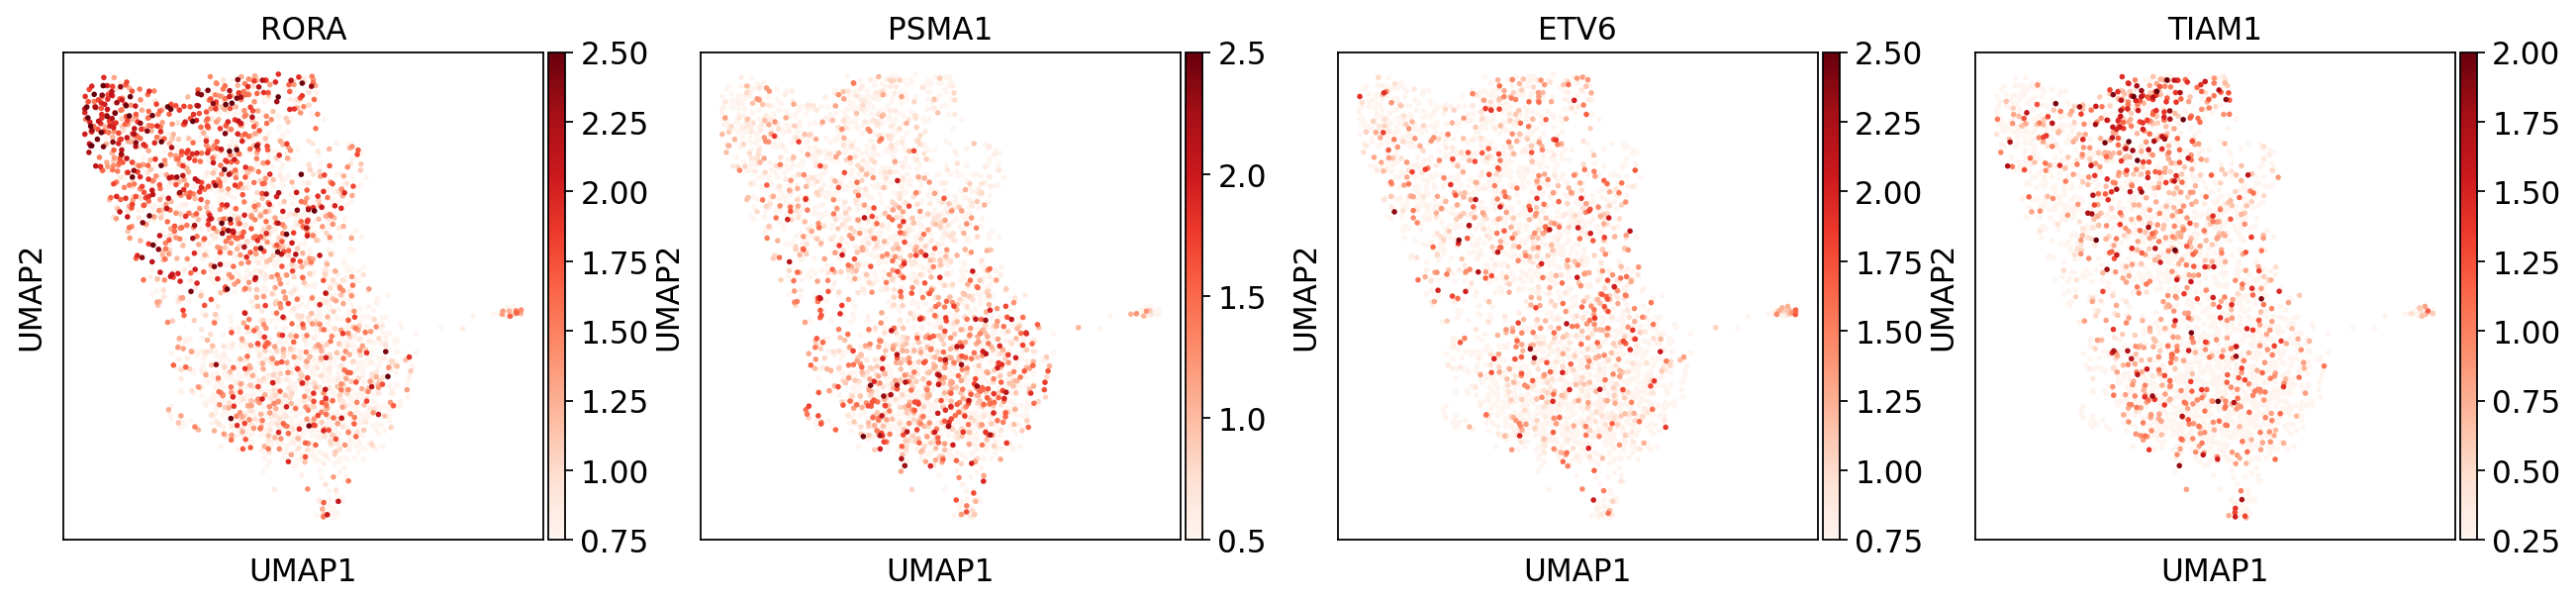

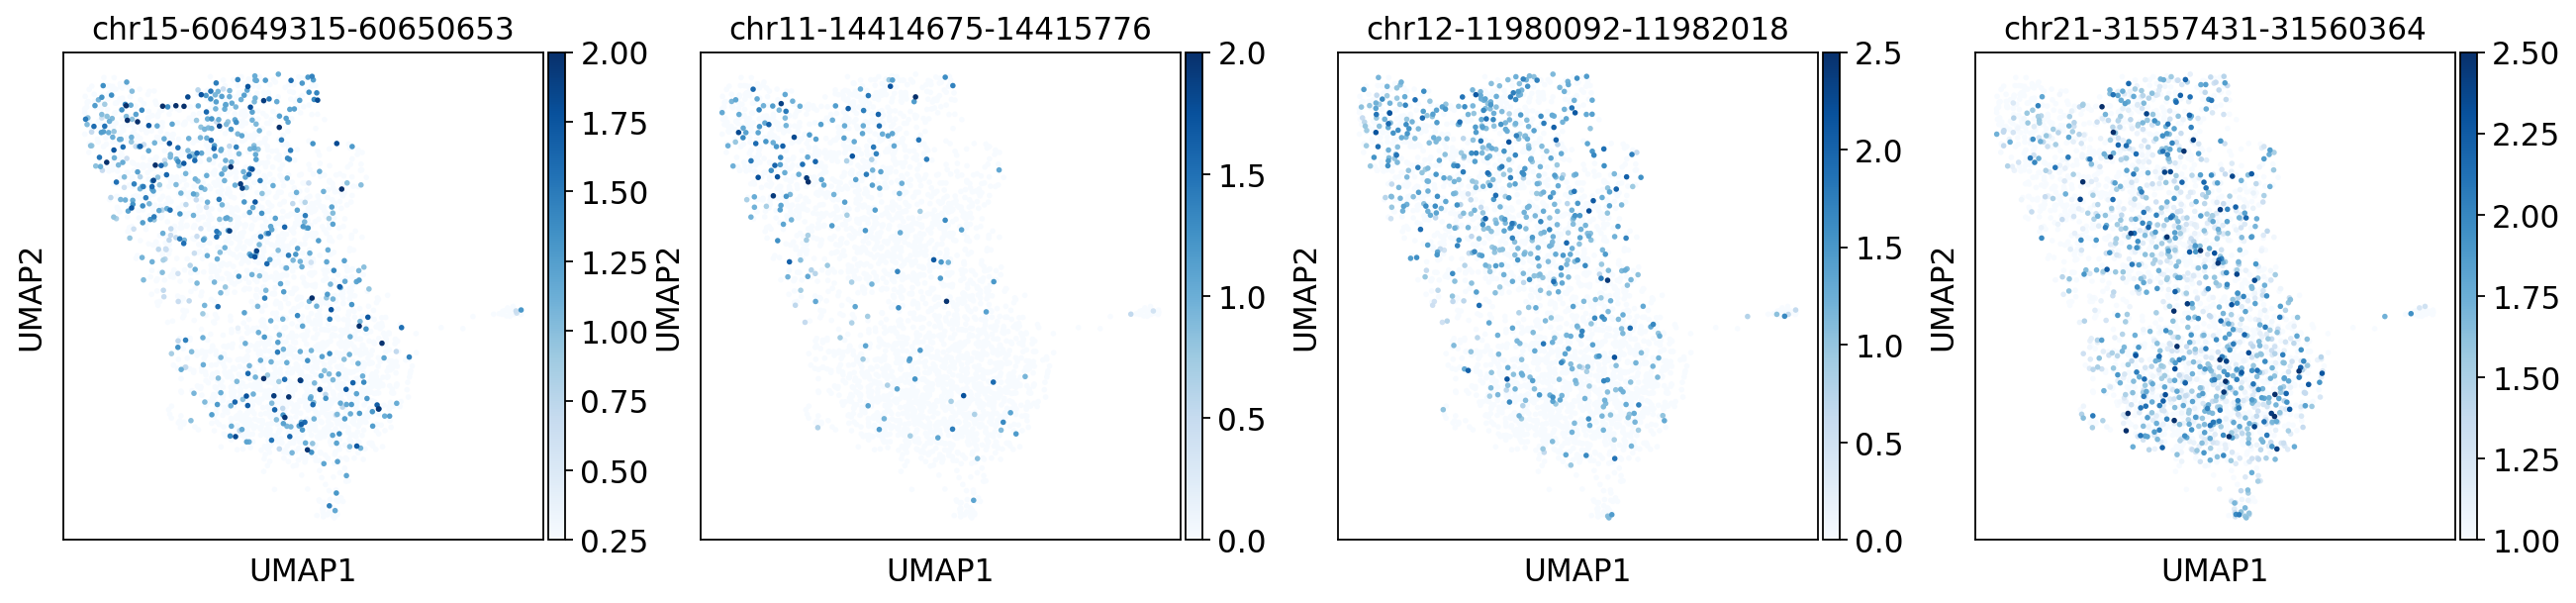

In [13]:
gene_list = []
peak_list = []

for feature in feature_list:
    gene_list.append(feature.split('_')[0])
    peak_list.append(feature.split('_')[1])
    
sc.pl.umap(anndat_mod1, color=gene_list, cmap='Reds', size=25, vmin=[0.75,0.5,0.75,0.25], vmax=[2.5,2.5,2.5,2.0])
sc.pl.umap(anndat_mod2, color=peak_list, cmap='Blues', size=25, vmin=[0.25,0.0,0.0,1.0], vmax=[2,2.0,2.5,2.5])

In [11]:
peaks_nearby = pd.read_csv('results/10X.correlation.allpairs.csv')
peaks_nearby.loc[peaks_nearby['genes'].isin(gene_list) &
                 peaks_nearby['peaks'].isin(peak_list)]

genes                    peaks  tss_dist  pRegion  tts_dist  gBody  \
58895   PSMA1  chr11-14414675-14415776  228410.0        0   89649.0      0   
66105    ETV6  chr12-11980092-11982018  331381.0        0   85678.0      0   
79183    RORA  chr15-60649315-60650653  579318.0        0 -161700.0      1   
112919  TIAM1  chr21-31557431-31560364    1080.0        0 -440481.0      1   

               L     L.p_value         L.FDR  gene.pct  peak.pct         r  \
58895  -0.370301  9.665219e-12  1.584086e-09  0.456734  0.060014 -0.367033   
66105   0.355542  1.964674e-09  1.779140e-07  0.454641  0.218772  0.390910   
79183   0.375736  1.431414e-11  2.254407e-09  0.642708  0.189463  0.404195   
112919  0.248891  4.402158e-04  7.673807e-03  0.307746  0.513259  0.303174   

           r.p_value         r.FDR  
58895   8.098115e-65  9.340874e-63  
66105   5.138051e-74  7.353729e-72  
79183   1.789418e-79  2.874371e-77  
112919  8.636918e-44  5.950673e-42

### Local L examples for statistical test

In [2]:
# Calculate Moran's I
import multiome.graph_measure as graph_measure
ad_pb_all = ad.read_h5ad('../data/10XMultiome/10XPBMC.all.pseudo.h5ad')
ad_pb_all = graph_measure.Morans_I(ad_pb_all)

/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


Following changes made to the AnnData object:
	Moran's I value saved in var['Morans.I']
42.854s past


In [3]:
# load and preprocess the single-cell data
anndat_mod1 = ad.read_h5ad('../data/10XMultiome/PBMC_10X_GEX.h5ad')
anndat_mod2 = ad.read_h5ad('../data/10XMultiome/PBMC_10X_ATAC.peak.h5ad')

anndat_mod1.X = anndat_mod1.layers['counts'].copy()
rna_umap = pd.read_csv('../data/10XMultiome/PBMC.rna.umap.csv').to_numpy()
anndat_mod1.obsm['X_umap'] = rna_umap
anndat_mod2.obsm['X_umap'] = rna_umap

sc.pp.normalize_total(anndat_mod1)
sc.pp.normalize_total(anndat_mod2)
sc.pp.log1p(anndat_mod1)
sc.pp.log1p(anndat_mod2)


In [5]:
# Calculate local L
start = time.time()
ad_pb_all = graph_measure.Global_L(ad_pb_all, permutations=0)
print('Finished in %.2fs.'%(time.time()-start))

start = time.time()
ad_pb_all = graph_measure.Local_L_bygroup(ad_pb_all,
                                   groupby='seurat_annotations',
                                  I_cutoff=0.5,
                                  pct_cutoff=0,
                                  dropout_rm=True,
                                  permutations=0)

print('Finished in %.2fs.'%(time.time()-start))

Calculating global graph-based correlation value...
Following changes made to the AnnData object:
	Global L results and QC metrics updated in uns['peaks_nearby'].
Finished in 71.75s.
Filtering features by Moran's I and feature sparsity in single-cell data...
Previously calculated Moran's I found.
Keep features with Moran's I > 0.5 and at least 0% expressed in single-cell data...
21328 pairs left for graph-based correlation L calculation.

Calculating local graph-based correlation value...
Set L to 0 for cells with no expression on either feature of a certain pair...
Following changes made to the AnnData object:
	Graph-based Pearson Correlation results saved in uns['Local_L_by_seurat_annotations']
	uns['peaks_nearby']['Local_L_by_seurat_annotations'] added indicates feature selected for per group local L calculation or not.
Finished in 25.07s.


In [6]:
ad_pb_all.var.loc[['FOXP1','chr3-71031152-71032373']]

mean       std  Frac.all  Frac.CD14 Mono  \
FOXP1                   6.679187  1.795863  0.943527        0.969417   
chr3-71031152-71032373  0.629897  0.844606  0.048406        0.020626   

                        Frac.CD16 Mono  Frac.CD4 Naive  Frac.CD4 TCM  \
FOXP1                         0.978599        0.985201      0.959965   
chr3-71031152-71032373        0.040856        0.036646      0.020017   

                        Frac.CD4 TEM  Frac.CD8 Naive  Frac.CD8 TEM_1  ...  \
FOXP1                       0.916107        0.996454        0.883077  ...   
chr3-71031152-71032373      0.030201        0.055319        0.006154  ...   

                        n_cells  n_cells_by_counts  mean_counts  \
FOXP1                      5000             5000.0   111.403534   
chr3-71031152-71032373     2117                NaN          NaN   

                        pct_dropout_by_counts  total_counts     means  \
FOXP1                                     0.0   557017.6875  7.284967   
chr3-71031152-71032373                    NaN           NaN       NaN   

                        dispersions  dispersions_norm  variances_norm  \
FOXP1                      5.895209         -0.817382        2.428005   
chr3-71031152-71032373          NaN               NaN             NaN   

                        Morans.I  
FOXP1                   0.913593  
chr3-71031152-71032373  0.630071  

[2 rows x 32 columns]

In [7]:
import multiome.visualization as visualization
import multiome.data_preparation as data_preparation


Mapping back from mini-bulk to single-cell data...

Compensating missing cells by its 5 neighbors in X_umap...

Following infos added to the AnnData:
	FOXP1_chr3-71031152-71032373 labels	obs['FOXP1_chr3-71031152-71032373']


/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


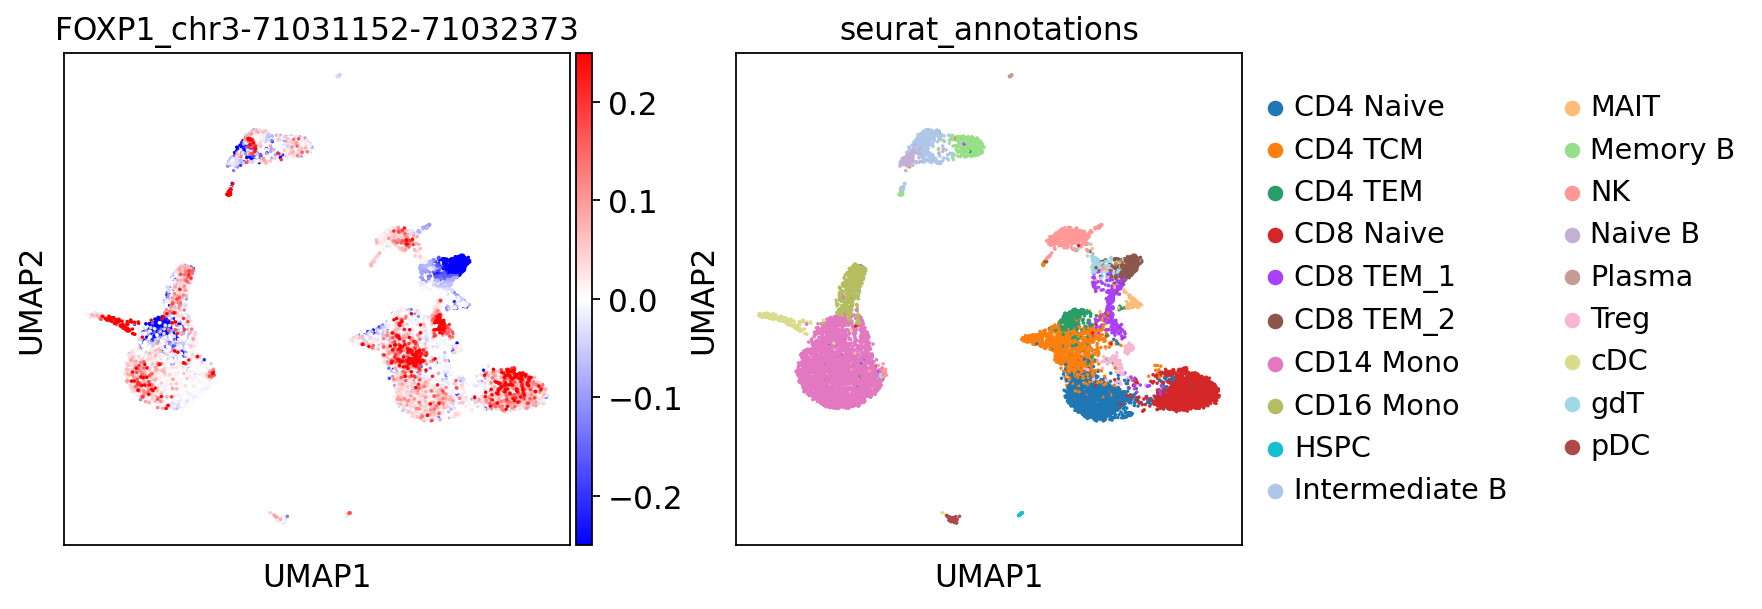

In [10]:
feature = 'FOXP1_chr3-71031152-71032373'
gene = feature.split('_')[0]
peak = feature.split('_')[1]
gene_mean = float(ad_pb_all[:,gene].X.mean())
peak_mean = float(ad_pb_all[:,peak].X.mean())
gvrange = 1.0
pvrange = 1.0

#visualization.visualize_marker(ad_pb_all, gene, peak,
#                               vmin=[max(0,gene_mean-gvrange),max(0,peak_mean-pvrange),-1],
#                               vmax=[gene_mean+gvrange,peak_mean+pvrange,1], size=10)

peaks_nearby = ad_pb_all.uns['peaks_nearby'].copy()
feature_index = np.arange(len(peaks_nearby))[(peaks_nearby['genes']==gene) & 
                                             (peaks_nearby['peaks']==peak)][0]

_, n_col = ad_pb_all.obs.shape
anndat_sp_L = pd.DataFrame(ad_pb_all.uns['Local_L_by_seurat_annotations'])
anndat_sp_L.columns = ad_pb_all.uns['Local_L_by_seurat_annotations_names']
ad_pb_all.obs['%s_%s'%(gene,peak)] = anndat_sp_L['%s_%s'%(gene,peak)].to_numpy()

anndat_mod1 = data_preparation.map_back_sc(anndat_mod1, ad_pb_all,
                                           label=feature,
                                           embed='X_umap')

sc.pl.umap(anndat_mod1, color=[feature,'seurat_annotations'],
       cmap='bwr', vmin=-0.25, vmax=0.25, size=10)